In [1]:
import sys 
import xarray as xr
import numpy as np
import os 
import math

In [2]:
coords = xr.open_dataset('/home/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
mask = xr.open_dataset('/home/jvalenti/MOAD/grid2/mesh_mask202108_TDV.nc')

In [3]:
def latT(lat):
    return np.cos(lat*(math.pi/180))

def count_inside_grid_cell(center_x, center_y, cell_width, cell_height, x,y,Ni):
    deg2met = 111319.5
    cell_width = cell_width/(deg2met*latT(center_y))
    cell_height = cell_height/deg2met
    min_x = np.array(center_x - cell_width / 2)
    min_y = np.array(center_y - cell_height / 2)
    max_y = np.array(center_y + cell_height*(Ni-0.5))
    max_x = np.array(center_x + cell_width*(Ni-0.5))
    
    
    inside_mask = np.logical_and.reduce([
        min_x[:, np.newaxis] <= x,
        x <= max_x[:, np.newaxis],
        min_y[:, np.newaxis] <= y,
        y <= max_y[:, np.newaxis]
    ])
    c = np.sum(inside_mask,axis=1)
    return c

def conc_OP(filename,Ni=1):
    print(filename[0])
    ds = xr.open_dataset(filename[0],decode_times=False)
    MFc = 5e6
    #zlevels = [0,5,10,50,100,800]
    zlevels = mask.gdepw_0[0,:,1,1].values
    DS=ds.to_dataframe()
    #DS = DS[DS.z < 800]
    DS = DS[DS.status==1]
    lat = coords.nav_lat[::Ni,::Ni]
    lon = coords.nav_lon[::Ni,::Ni]
    td = mask.totaldepth
    cell_width = coords.e1t[0,::Ni,::Ni]
    cell_height = coords.e2t[0,::Ni,::Ni]
    x = np.array(DS.lon)
    y = np.array(DS.lat)
    z = np.array(DS.z)

    conc = np.zeros((len(zlevels),coords.nav_lon.shape[0],coords.nav_lon.shape[1]))
    for k in range(len(zlevels)):
        print(f'{k} level starting.')  
        for j in range(coords.nav_lon.shape[0]):
            zmin = int(zlevels[k])
            X = x[np.logical_and(z >= zmin)]
            Y = y[np.logical_and(z >= zmin)]
            BOXarea = (cell_width[j,:]* cell_height[j,:])
            #BOXvolume = (cell_width[j,:]* cell_height[j,:]*(td[j,:]-zmin))
            conc[k,j,:]+= count_inside_grid_cell(lon[j,:], lat[j,:], cell_width[j,:], cell_height[j,:],X,Y,Ni)*MFc/BOXarea
    for k in range(len(zlevels)-1):
        conc[k,:,:] = (conc[k,:,:]-conc[k+1,:,:])/(zlevels[k]-zlevels[k+1])

    np.save('concentration_test.npy',conc)

In [4]:
Ni = 50
filename = ['/home/jvalenti/MOAD/results/Graham/Runs_alpha0120190101_.nc']

In [5]:
def conc_OP(filename,Ni=1):
    print(filename[0])
    ds = xr.open_dataset(filename[0],decode_times=False)
    MFc = 1e7/40
    #zlevels = [0,5,10,50,100,800]
    zlevels = mask.gdepw_0[0,:,1,1].values
    DS=ds.to_dataframe()
    #DS = DS[DS.z < 800]
    DS = DS[DS.status==1]
    DS = DS[DS.time>1728000]
    lat = coords.nav_lat[::Ni,::Ni]
    lon = coords.nav_lon[::Ni,::Ni]
    td = mask.totaldepth
    cell_width = coords.e1t[0,::Ni,::Ni]
    cell_height = coords.e2t[0,::Ni,::Ni]
    x = np.array(DS.lon)
    y = np.array(DS.lat)
    z = np.array(DS.z)

    conc = np.zeros([len(zlevels),len(coords.nav_lon[::Ni,0]),len(coords.nav_lon[0,::Ni])])
    for k in range(len(zlevels)):
        #print(f'{k} level starting.')  
        for j in range(len(coords.nav_lon[0,::Ni])):
            zmin = int(zlevels[k])
            X = x[z >= zmin]
            Y = y[z >= zmin]
            BOXarea = (cell_width[:,j]* cell_height[:,j])*Ni**2
            #BOXvolume = (cell_width[j,:]* cell_height[j,:]*(td[j,:]-zmin))
            conc[k,:,j]+= count_inside_grid_cell(lon[:,j], lat[:,j], cell_width[:,j], cell_height[:,j],X,Y,Ni)*MFc/BOXarea
    for k in range(len(zlevels)-1):
        conc[k,:,:] = (conc[k,:,:]-conc[k+1,:,:])/(zlevels[k+1]-zlevels[k])


In [6]:
def newgridcenter(center_x, center_y, cell_width, cell_height,Ni):
    deg2met = 111319.5
    cell_width = cell_width/(deg2met*latT(center_y))
    cell_height = cell_height/deg2met
    min_x = np.array(center_x - cell_width / 2)
    min_y = np.array(center_y - cell_height / 2)
    max_y = np.array(center_y + cell_height*(Ni-0.5))
    max_x = np.array(center_x + cell_width*(Ni-0.5))
    return (max_x+min_x)/2,(max_y+min_y)/2

X , Y = newgridcenter(lon, lat, cell_width, cell_height,Ni)
conc = conc *40

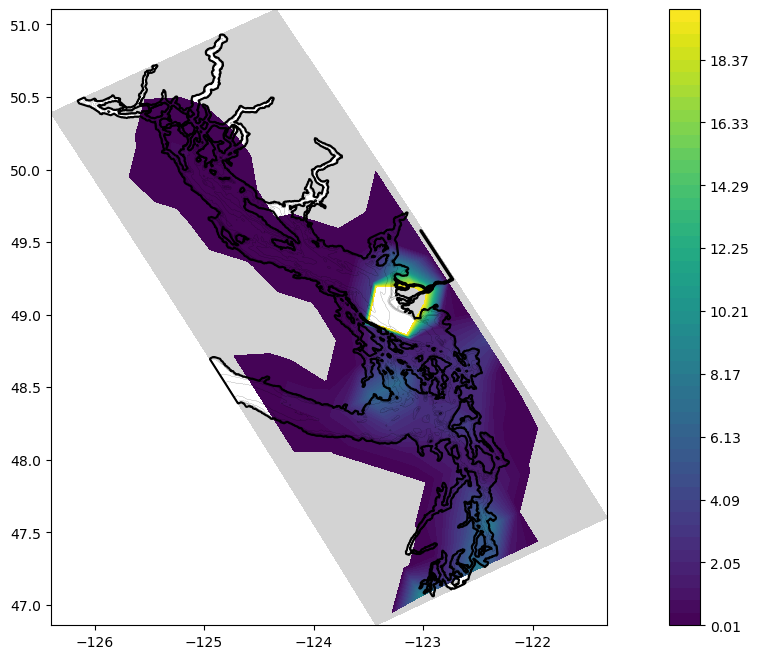

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

levels = np.linspace(1e-2,20,50)
fig, ax = plt.subplots(1,1,figsize=(16, 8))

ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_aspect(1/np.sin(np.deg2rad(49)))
aa = plt.contourf(X,Y,conc[0,:,:],levels=levels)
plt.colorbar(aa)


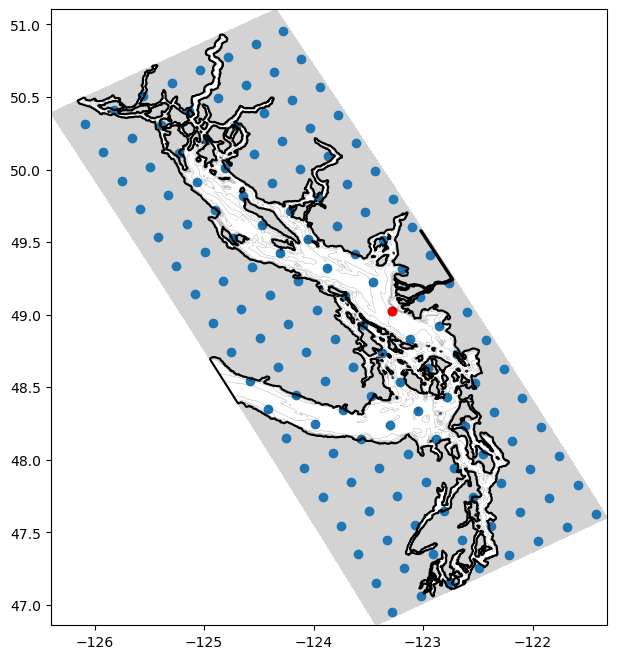

In [11]:
fig, ax = plt.subplots(1,1,figsize=(16, 8))
ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
aa = plt.scatter(X,Y)
ax.set_aspect(1/np.sin(np.deg2rad(49)))
plt.scatter(X[8, 5],Y[8, 5],c='r')

In [56]:
conc = conc /40

Text(0.5, 1.0, 'JdF')

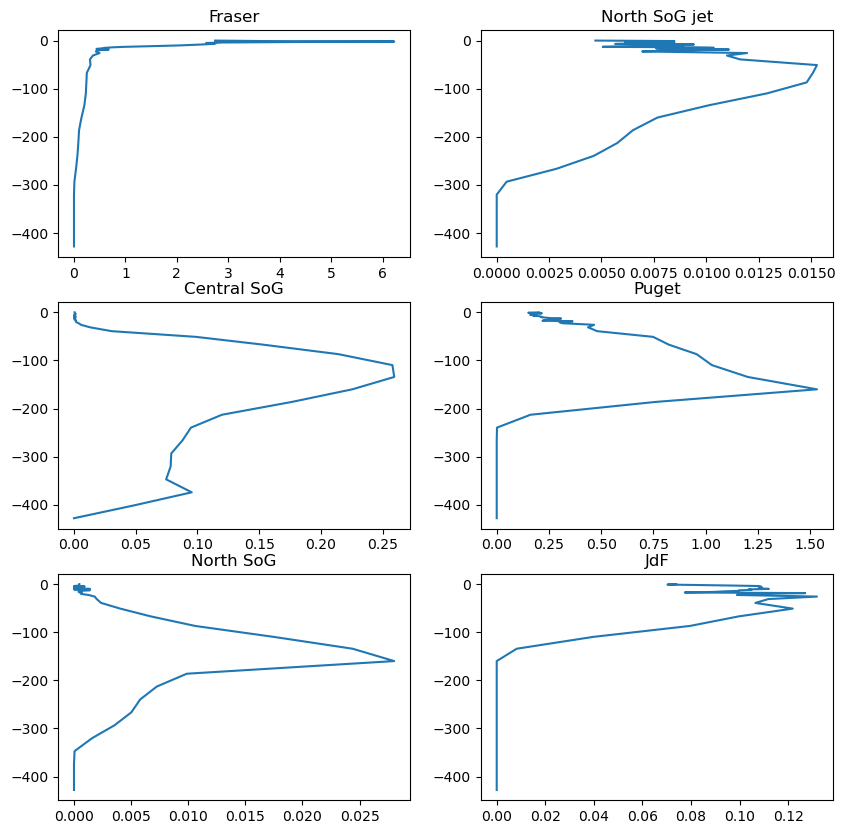

In [57]:
fig,axs = plt.subplots(3,2,figsize=(10,10))
axs[0,0].plot(conc[:,8, 5],-zlevels)
axs[0,0].set_title('Fraser')
axs[1,0].plot(conc[:,10, 4],-zlevels)
axs[1,0].set_title('Central SoG')
axs[2,0].plot(conc[:,12, 3],-zlevels)
axs[2,0].set_title('North SoG')
axs[0,1].plot(conc[:,-4, 2],-zlevels)
axs[0,1].set_title('North SoG jet')
axs[1,1].plot(conc[:,1, 4],-zlevels)
axs[1,1].set_title('Puget')
axs[2,1].plot(conc[:,5, 3],-zlevels)
axs[2,1].set_title('JdF')

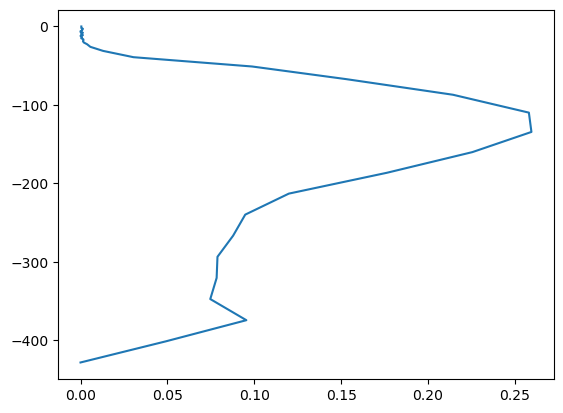

In [50]:
plt.plot(conc[:,10, 4],-zlevels)

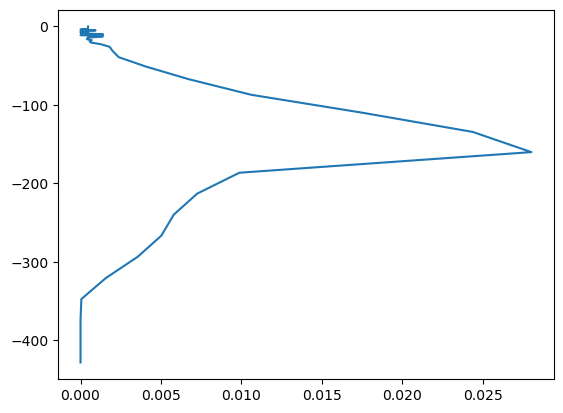

In [51]:
plt.plot(conc[:,12, 3],-zlevels)

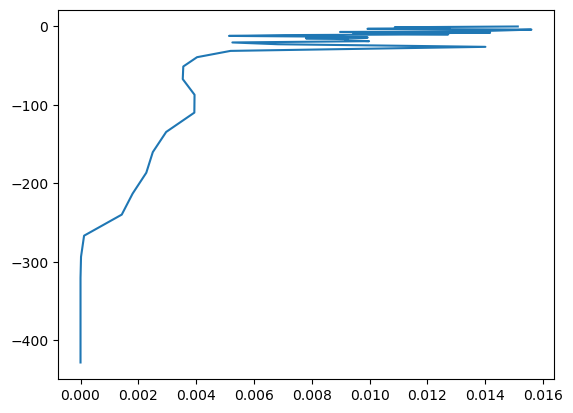

In [52]:
plt.plot(conc[:,15, 2],-zlevels)

In [53]:
np.unravel_index(np.argmax(conc, axis=None), conc.shape)

(2, 8, 5)